In [2]:
from datetime import datetime
import random
import numpy as np 
import networkx as nx 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.sparse import csr_matrix
from scipy.io import loadmat
from numpy.linalg import norm
from collections import Counter
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math

In [3]:
def parse_fb100_mat_file(filename):
    """ 
    Parse FB100 .mat files and remove nodes with missing gender or dorm.
    
    Metadata values:
        0 - student/faculty status
        1 - gender
        2 - major
        3 - second major/minor
        4 - dorm/house
        5 - year
        6 - high school
    ** Missing data coded as 0 **
    
    Parameters:
      - filename: path to FB100 .mat file

    Returns:
      (adj_matrix, metadata)
         adj_matrix: cleaned adjacency matrix (only nodes with gender ≠ 0 and dorm ≠ 0)
         metadata: corresponding metadata for remaining nodes
    """
    mat = loadmat(filename)
    error_msg = "%s is not a valid FB100 .mat file. Must contain variable '%s'"
    
    if 'A' not in mat:
        raise ValueError(error_msg % (filename, 'A'))
    adj_matrix = mat['A']
    
    if 'local_info' not in mat:
        raise ValueError(error_msg % (filename, 'local_info'))
    metadata = mat['local_info']
    
    # Remove nodes with missing gender or dorm (both coded as 0)
    gender = metadata[:, 1]
    dorm = metadata[:, 4]
    valid_nodes = np.where((gender != 0) & (dorm != 0))[0]

    metadata = metadata[valid_nodes]
    adj_matrix = csr_matrix(adj_matrix)  # ensure sparse format
    adj_matrix = adj_matrix[valid_nodes][:, valid_nodes]

    return adj_matrix, metadata

In [4]:
def create_multi_dorm_core_fringe_graph(adj_matrix, metadata, target_dorm_ids):
    """
    Creates a core-fringe graph for a given list of dormIDs.
    Core nodes are those whose dorm is in target_dorm_ids.
    Fringe nodes are any nodes that are connected to at least one core node,
    but are not themselves core nodes.
    
    Parameters:
      - adj_matrix (scipy.sparse matrix): full graph adjacency matrix.
      - metadata (np.array): metadata for each node.
      - target_dorm_ids (list or array-like): dorm IDs to be used for the core.
      
    Returns:
      (core_fringe_adj, core_indices, fringe_indices)
         core_fringe_adj: the adjacency matrix after preserving edges only between core-core and core-fringe nodes.
         core_indices: indices (with respect to adj_matrix) of nodes belonging to any dorm in target_dorm_ids.
         fringe_indices: indices (with respect to adj_matrix) of nodes that are connected to the core but not in it.
    """
    dorms = metadata[:, 4]
    # Select core nodes: those whose dorm is in target_dorm_ids.
    core_indices = np.where(np.isin(dorms, target_dorm_ids))[0]
    is_core = np.zeros(adj_matrix.shape[0], dtype=bool)
    is_core[core_indices] = True

    # Ensure CSR format.
    A = csr_matrix(adj_matrix)
    
    # Print total number of edges in the original adjacency
    total_edges_original = int(A.nnz / 2)
    print(f"Total edges in original adjacency: {total_edges_original}")
    # Find all neighbors of the core nodes.
    neighbors = A[core_indices].nonzero()[1]
    # Fringe nodes: those connected to core nodes but not in core.
    fringe_indices = np.setdiff1d(np.unique(neighbors), core_indices)
    
    # Build a mask that keeps only core-core and core-fringe edges.
    # Create sparse mask matrix
    mask_data = []
    mask_rows = []
    mask_cols = []
    
    # Add core-core edges
    core_core_edges = A[core_indices][:, core_indices]
    for i, j in zip(*np.triu_indices_from(core_core_edges, k=1)):
        mask_rows.extend([core_indices[i], core_indices[j]])
        mask_cols.extend([core_indices[j], core_indices[i]])
        mask_data.extend([1, 1])
    
    # Add core-fringe edges
    core_fringe_edges = A[core_indices][:, fringe_indices]
    for i, j in zip(core_fringe_edges.nonzero()[0], core_fringe_edges.nonzero()[1]):
        mask_rows.extend([core_indices[i], fringe_indices[j]])
        mask_cols.extend([fringe_indices[j], core_indices[i]])
        mask_data.extend([1, 1])

    # Create sparse mask matrix
    mask = csr_matrix((mask_data, (mask_rows, mask_cols)), shape=A.shape)

    core_fringe_adj = A.multiply(mask)

    print(f"Multi-dorm core using dormIDs {target_dorm_ids}")
    print(f"Core size: {len(core_indices)}")
    core_core_edges = int(np.sum(core_fringe_adj[core_indices][:, core_indices]) / 2)
    core_fringe_edges = int(np.sum(core_fringe_adj[core_indices][:, fringe_indices]) / 2)
    print(f"Number of core-core edges: {core_core_edges}")
    print(f"Number of core-fringe edges: {core_fringe_edges}")
    
    # Calculate number of fringe-fringe edges lost
    fringe_fringe_edges = total_edges_original - (core_core_edges + core_fringe_edges)
    print(f"Number of fringe-fringe edges (lost): {fringe_fringe_edges}")

    # After constructing core_fringe_adj
    fringe_adj = core_fringe_adj[fringe_indices, :][:, fringe_indices]
    assert fringe_adj.nnz == 0, "Fringe-fringe edges exist in the core-fringe adjacency matrix!"

    return core_fringe_adj, core_indices, fringe_indices

In [41]:
def fill_fringe_fringe_jaccard(adj_matrix, fringe_indices, threshold=0.5):
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    # go over all pairs of fringe-fringe and compute the jaccard sim of their adj_list
    # and if above threshold add an edge between the nodes and return this A_pred
    neighbor_set = {}
    for node in fringe_indices:
        neighbor_set[node] = set(np.nonzero(A[node])[0])

    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1, L):
            v = fringe_indices[j]
            
            # skip if already added edge
            if A_pred[u, v] > 0:
                continue
                
            neighbors_u = neighbor_set[u]
            neighbors_v = neighbor_set[v]

            union_size = len(neighbors_u | neighbors_v)
            if union_size == 0:
                sim = 0.0
            else:
                sim = len(neighbors_u & neighbors_v) / union_size 
            # print(f"Jaccard Sim: {sim}")
            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1
    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_jaccard_inverse(adj_matrix, fringe_indices, threshold=0.5):
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    # go over all pairs of fringe-fringe and compute the jaccard sim of their adj_list
    # and if above threshold add an edge between the nodes and return this A_pred
    neighbor_set = {}
    for node in fringe_indices:
        neighbor_set[node] = set(np.nonzero(A[node])[0])

    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1, L):
            v = fringe_indices[j]
            
            # skip if already added edge
            if A_pred[u, v] > 0:
                continue
                
            neighbors_u = neighbor_set[u]
            neighbors_v = neighbor_set[v]

            union_size = len(neighbors_u | neighbors_v)
            if union_size == 0:
                sim = 0.0
            else:
                sim = 0.5 - len(neighbors_u & neighbors_v) / union_size 
            # print(f"Jaccard Sim: {sim}")
            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1
    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_cosine(adj_matrix, core_indices, fringe_indices, labels, threshold=0.5):
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    # go over all fringe nodes, and make a 2D vector : [# of class 1 nghs, # of class 2 nghs]
    # compute the cosine between this to add an edge between fringe nodes 
    core_classes = labels[core_indices].astype(int)
    class_labels = np.unique(core_classes)
    fringe_vecs = {}
    for u in fringe_indices:
        vec = np.zeros(2, dtype=int)
        neighbors = np.where(A[u, core_indices] > 0)[0]
        for idx in neighbors:
            cls = core_classes[idx]
            if cls == class_labels[0]:
                vec[0] += 1
            elif cls == class_labels[1]:
                vec[1] += 1
        fringe_vecs[u] = vec

    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1,L):
            v = fringe_indices[j]

            # skip if already added edge
            if A_pred[u, v] > 0:
                continue

            vec_u = fringe_vecs[u]
            vec_v = fringe_vecs[v]
            if norm(vec_u) == 0 or norm(vec_v) == 0:
                sim = 0.0
            else:
                sim = np.dot(vec_u, vec_v) / (norm(vec_u) * norm(vec_v))

            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1

    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_cosine_adj(adj_matrix, fringe_indices, labels, threshold=0.5):
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1,L):
            v = fringe_indices[j]

            # skip if already added edge
            if A_pred[u, v] > 0:
                continue

            vec_u = A[u,:]
            vec_v = A[v,:]
            if norm(vec_u) == 0 or norm(vec_v) == 0:
                sim = 0.0
            else:
                sim = np.dot(vec_u, vec_v) / (norm(vec_u) * norm(vec_v))
                # print(f"Cosine Sim: {sim}")

            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1

    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_adamic_adar(adj_matrix, fringe_indices, labels, threshold=0.5):
    # fill ff using Adamic/Adar score
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    neighbor_set = {}
    for node in fringe_indices:
        neighbor_set[node] = set(np.nonzero(A[node])[0])

    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1, L):
            v = fringe_indices[j]
            
            # skip if already added edge
            if A_pred[u, v] > 0:
                continue
                
            neighbors_u = neighbor_set[u]
            neighbors_v = neighbor_set[v]

            intersection = neighbors_u & neighbors_v
            
            if len(intersection) == 0:
                sim = 0.0
            else:
                sim = 0.0
                for w in intersection:
                    deg_w = len(set(np.nonzero(A[w])[0]))
                    if deg_w <= 1:
                        continue
                    sim += 1 / math.log(deg_w)
            # print(f"Adamic/Adar Sim: {sim}")
            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1
    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_jaccard_class_based(adj_matrix, core_indices, fringe_indices, labels, label_index=0, threshold=0.5):
    """
    Class-1 Jaccard: J1 is Jaccard similarity computed using only class-1 neighbors among core nodes.
    """
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()

    core_classes = labels[core_indices].astype(int)
    unique_classes = np.unique(core_classes)
    if unique_classes.size < 2:
        raise ValueError("Expected at least two classes among core nodes for class-based Jaccard.")
    class_label = unique_classes[label_index]

    # Build per-fringe neighbor sets restricted to core nodes of class1 (absolute node indices)
    fringe_neighbors_class1 = {}
    for u in fringe_indices:
        # indices (relative) of core nodes that are neighbors
        rel_idxs = np.where(A[u, core_indices] > 0)[0]
        # filter those that belong to class_label
        core_rel_class_label = [ri for ri in rel_idxs if core_classes[ri] == class_label]
        # convert to absolute node ids
        abs_nodes = set(core_indices[ri] for ri in core_rel_class_label)
        fringe_neighbors_class1[u] = abs_nodes

    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i + 1, L):
            v = fringe_indices[j]
            if A_pred[u, v] > 0:
                continue
            Nu = fringe_neighbors_class1[u]
            Nv = fringe_neighbors_class1[v]
            union_size = len(Nu | Nv)
            sim = 0.0 if union_size == 0 else len(Nu & Nv) / union_size
            if sim >= threshold:
                A_pred[u, v] = 1.0
                A_pred[v, u] = 1.0
                added_edges += 1

    possible_pairs = L * (L - 1) 
    print(f"Possible FF pairs : {possible_pairs} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_katz(adj_matrix, fringe_indices, threshold=0.5, beta=0.01, weighted=False, bool_katz_kmax=10, bool_tol=1e-6):
    """
    Fill fringe-fringe edges using Katz similarity.

    Two modes controlled by `weighted`:
      - weighted=True: standard Katz using numeric adjacency A (counts multiplicities).
        K = (I - beta A)^{-1} - I
        Requires beta * spectral_radius(A) < 1 (function will reduce beta if needed).
      - weighted=False: existence-based (unweighted) Katz:
        For each path length k, compute boolean connectivity matrix B_k (entries 0/1:
        whether at least one walk/path of length k exists). Then compute
          K_bool = sum_{k=1..k_max} beta^k * B_k
        Note: B_k is computed via boolean-matrix-multiplication using `(prev @ A_bin > 0).astype(int)`.
        We sum up to `bool_katz_kmax` or stop early if beta^k < bool_tol.

    Parameters
    ----------
    adj_matrix : array-like or scipy sparse matrix
    core_indices, fringe_indices : iterables of ints (used to pick fringe nodes to consider)
    labels : not used (kept for signature compatibility)
    threshold : float - add edge if Katz(u,v) >= threshold
    beta : float - attenuation factor
    weighted : bool - if True use weighted Katz, else use existence-based unweighted Katz
    bool_katz_kmax : int - max path length to consider in unweighted (existence) Katz
    bool_tol : float - stop if beta**k < bool_tol (unweighted mode)

    Returns
    -------
    A_pred : np.ndarray  (dense adjacency with new edges added)
    added_edges : int    (number of undirected edges added)
    """
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    n = A.shape[0]
    import warnings
    if weighted:
        # --- Weighted Katz: numeric walk counts (classic) ---
        # compute spectral radius (try eigvals, fall back to power iteration)
        try:
            eigvals = np.linalg.eigvals(A)
            spectral_radius = max(abs(eigvals))
        except Exception:
            # power iteration fallback
            x = np.random.randn(n)
            x /= np.linalg.norm(x) if np.linalg.norm(x) != 0 else 1.0
            for _ in range(50):
                x = A.dot(x)
                norm_x = np.linalg.norm(x)
                if norm_x == 0:
                    break
                x = x / norm_x
            spectral_radius = np.linalg.norm(A.dot(x)) / (np.linalg.norm(x) + 1e-12)

        if spectral_radius == 0:
            K = np.zeros_like(A)
        else:
            max_beta = 1.0 / spectral_radius
            if beta >= max_beta:
                warnings.warn(
                    f"Provided beta={beta:.4g} >= 1/spectral_radius={max_beta:.4g}. "
                    f"Reducing beta to 0.9*(1/spectral_radius) for stability."
                )
                beta = 0.9 * max_beta
            I = np.eye(n)
            M = I - beta * A
            try:
                invM = np.linalg.inv(M)
            except np.linalg.LinAlgError:
                invM = np.linalg.solve(M, I)
            K = invM - I

    else:
        # --- Unweighted/existence-based Katz ---
        # Binarize adjacency (treat any positive weight as edge)
        A_bin = (A > 0).astype(int)
        if A_bin.sum() == 0:
            K = np.zeros_like(A, dtype=float)
        else:
            # Compute B_k iteratively: B_1 = A_bin, B_{k+1} = (B_k @ A_bin > 0).astype(int)
            K = np.zeros_like(A, dtype=float)
            Bk = A_bin.copy()            # paths of length 1
            k = 1
            while k <= bool_katz_kmax:
                coeff = (beta ** k)
                if coeff < bool_tol:
                    break
                # add weighted boolean indicator for length k
                K += coeff * Bk.astype(float)
                # compute next power (boolean multiplication)
                next_Bk = (Bk.dot(A_bin) > 0).astype(int)
                # If next_Bk is all zeros, no further lengths will contribute
                if next_Bk.sum() == 0:
                    break
                Bk = next_Bk
                k += 1

    # Now we have similarity matrix K (float). Fill fringe-fringe edges where sim >= threshold.
    A_pred = A.copy()
    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i + 1, L):
            v = fringe_indices[j]
            if A_pred[u, v] > 0:
                continue
            sim = K[u, v]
            # numerical guard
            print(f"Katz Sim: {sim}")
            if sim < 0 and sim > -1e-12:
                sim = 0.0
            if sim >= threshold:
                A_pred[u, v] = 1.0
                A_pred[v, u] = 1.0
                added_edges += 1

    possible_pairs = L * (L - 1) 
    print(f"Possible FF pairs: {possible_pairs} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def fill_fringe_fringe_match_core_topology(
    adj_matrix,
    core_indices,
    fringe_indices,
    method='chung-lu',
    preserve_existing=True,
    seed=None
):
    """
    Fill the fringe-fringe block so it matches the core-core topology according to `method`.

    Parameters
    ----------
    adj_matrix : array-like or sparse
        Full adjacency matrix (assumed undirected). Converted to dense numpy array.
    core_indices : iterable of int
        Indices of core nodes.
    fringe_indices : iterable of int
        Indices of fringe nodes to fill.
    method : str, one of {'chung-lu', 'erdos-renyi', 'permute'}
        'permute'    : require len(core)==len(fringe). Copy core-core adjacency after random permutation.
        'chung-lu'   : match degree distribution via Chung-Lu model (works for different sizes).
        'erdos-renyi': match global edge density (probability) of the core-core block.
    preserve_existing : bool
        If True, keep edges already present in the fringe-fringe block (only add missing ones).
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    A_pred : np.ndarray
        Dense adjacency matrix with new fringe-fringe edges added.
    added_edges : int
        Number of undirected fringe-fringe edges added.
    """
    rng = np.random.default_rng(seed)

    # Dense adjacency
    A = adj_matrix.toarray() if hasattr(adj_matrix, "toarray") else np.array(adj_matrix)
    A_pred = A.astype(float).copy()

    core_idx = np.array(core_indices, dtype=int)
    fringe_idx = np.array(fringe_indices, dtype=int)

    n_core = len(core_idx)
    n_fringe = len(fringe_idx)

    if n_core == 0 or n_fringe == 0:
        print("Empty core or fringe; nothing to do.")
        return A_pred, 0

    # Extract core-core adjacency and binarize (treat any positive weight as edge)
    core_block = (A[np.ix_(core_idx, core_idx)] > 0).astype(int)

    # Possible undirected edges count in core (exclude diagonal)
    possible_core_pairs = n_core * (n_core - 1) // 2
    core_edge_count = core_block.sum() // 2  # undirected edges assuming symmetry
    core_density = core_edge_count / possible_core_pairs if possible_core_pairs > 0 else 0.0

    new_FF = np.zeros((n_fringe, n_fringe), dtype=int)  # adjacency to create for fringe-fringe

    if method == 'permute':
        if n_core != n_fringe:
            raise ValueError("method='permute' requires core and fringe to have equal sizes.")
        # random permutation of core nodes -> an isomorphic copy
        perm = rng.permutation(n_core)
        permuted = core_block[np.ix_(perm, perm)]
        new_FF = permuted.copy()

    elif method == 'erdos-renyi':
        # sample each unordered pair with probability = core_density
        if core_density <= 0.0:
            new_FF[:] = 0
        else:
            # sample upper triangle
            iu = np.triu_indices(n_fringe, k=1)
            draws = rng.random(size=iu[0].shape) < core_density
            new_FF[iu] = draws.astype(int)
            # symmetrize
            new_FF = new_FF + new_FF.T

    elif method == 'chung-lu':
        # degree sequence in core (within core-block)
        deg_core = core_block.sum(axis=1).astype(float)  # length n_core
        # If all zero, no edges
        if deg_core.sum() == 0:
            new_FF[:] = 0
        else:
            # assign target degrees for fringe nodes
            if n_fringe == n_core:
                # map degrees directly but shuffle order to avoid one-to-one mapping
                perm = rng.permutation(n_core)
                deg_target = deg_core[perm].astype(float)
            else:
                # sample with replacement from core degree distribution
                # preserve distribution shape by sampling indices
                sample_idx = rng.integers(0, n_core, size=n_fringe)
                deg_target = deg_core[sample_idx].astype(float)

            # handle deg_target all zeros
            if deg_target.sum() == 0:
                new_FF[:] = 0
            else:
                total_degree = deg_target.sum()
                # Chung-Lu probabilities p_ij = (d_i * d_j) / total_degree
                # Build upper-triangular probabilities
                iu = np.triu_indices(n_fringe, k=1)
                di = deg_target[iu[0]]
                dj = deg_target[iu[1]]
                p_ij = (di * dj) / (total_degree + 1e-16)
                # Clip probabilities to [0,1]
                p_ij = np.minimum(p_ij, 1.0)
                draws = rng.random(size=p_ij.shape) < p_ij
                new_FF[iu] = draws.astype(int)
                new_FF = new_FF + new_FF.T

    else:
        raise ValueError(f"Unknown method: {method!r}. Choose 'permute','chung-lu', or 'erdos-renyi'.")

    # Now merge new_FF into the full adjacency A_pred (only for fringe-fringe pairs)
    added_edges = 0
    for i in range(n_fringe):
        u = fringe_idx[i]
        for j in range(i + 1, n_fringe):
            v = fringe_idx[j]
            want_edge = bool(new_FF[i, j])
            already = bool(A_pred[u, v] > 0)
            if want_edge and (not already or not preserve_existing):
                # add edge (undirected)
                A_pred[u, v] = 1.0
                A_pred[v, u] = 1.0
                if not already:
                    added_edges += 1

    possible_pairs = n_fringe * (n_fringe - 1) 
    print(f"Possible FF pairs: {possible_pairs} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

def _personalized_pagerank_root(A, root, alpha=0.15, tol=1e-8, max_iter=200):
    """
    Personalized PageRank (rooted at `root`) via power iteration.
    Returns a vector p (length n) that sums to 1 (numerically).
    Handles dangling nodes by redistributing their mass to the personalization vector.
    """
    n = A.shape[0]
    deg = A.sum(axis=1).astype(float)
    nonzero_mask = deg > 0

    # Build row-stochastic P implicitly by dividing rows when needed;
    # we'll use P^T @ p via explicit matrix for simplicity (dense).
    P = np.zeros_like(A, dtype=float)
    if nonzero_mask.any():
        P[nonzero_mask, :] = A[nonzero_mask, :] / deg[nonzero_mask, None]
    PT = P.T

    e_root = np.zeros(n, dtype=float)
    e_root[root] = 1.0

    p = e_root.copy()  # initialization biased to root for faster local convergence

    for _ in range(max_iter):
        dangling_mass = p[~nonzero_mask].sum() if (~nonzero_mask).any() else 0.0
        p_next = alpha * e_root + (1.0 - alpha) * (PT @ p + dangling_mass * e_root)
        if np.linalg.norm(p_next - p, 1) < tol:
            p = p_next
            break
        p = p_next

    s = p.sum()
    if s > 0:
        p /= s
    return p


def fill_fringe_fringe_rooted_pagerank(
        adj_matrix,
        fringe_indices,
        alpha=0.15,
        threshold=0.01,
        tol=1e-8,
        max_iter=200
    ):
    """
    One-direction rooted PageRank filling (compute p_u only once per u).
    For each ordered pair (u, v) with u < v (deterministic ordering), add undirected edge
    if p_u[v] >= threshold. No p_v is computed.

    Returns:
      A_pred : dense adjacency with added fringe-fringe edges
      added_edges : number of undirected edges added
    """
    A = adj_matrix.toarray() if hasattr(adj_matrix, "toarray") else np.array(adj_matrix)
    n = A.shape[0]
    A_pred = A.copy()

    # deterministic order for fringe nodes
    fringe_list = sorted(list(fringe_indices))
    L = len(fringe_list)
    added_edges = 0

    for i in range(L):
        u = fringe_list[i]
        # compute PPR rooted at u once
        p_u = _personalized_pagerank_root(A, u, alpha=alpha, tol=tol, max_iter=10)

        for j in range(i + 1, L):
            v = fringe_list[j]
            # skip if already present
            if A_pred[u, v] > 0:
                continue

            sim_uv = p_u[v]
            if sim_uv >= threshold:
                A_pred[u, v] = 1.0
                A_pred[v, u] = 1.0
                added_edges += 1

        # p_u is discarded here (no caching)

    possible_pairs = L * (L - 1) 
    print(f"Possible FF pairs: {possible_pairs} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

In [59]:
def _dense_adj(adj):
    return adj.toarray() if hasattr(adj, "toarray") else np.array(adj)

def _core_neighbors(A, core_idx):
    """Return dict absolute_node -> set(abs core neighbors)."""
    core_idx = np.array(core_idx, dtype=int)
    Ac = A[np.ix_(core_idx, core_idx)]
    neigh = {}
    for i, u in enumerate(core_idx):
        rel = np.nonzero(Ac[i, :])[0]
        neigh[u] = set(core_idx[rel])
    return neigh

def _common_neighbors_count(neigh_core, u, v_core_neighbors):
    """
    Compute number of common core neighbors between core node u (in neigh_core)
    and node v whose neighbors-to-core are provided as a set v_core_neighbors (absolute indices).
    """
    Nu = neigh_core.get(u, set())
    return len(Nu & v_core_neighbors)

def impute_ff_inception(adj_matrix,
                        core_indices,
                        fringe_indices,
                        labels,
                        threshold=0.5,
                        top_k=None,
                        seed=None,
                        lr_kwargs=None):
    """
    Simple imputation using a model trained only on edge structure (common neighbors).
    Training:
      - Use core nodes and their labels.
      - For class A as 'core' and class B as 'fringe' (and swapped), create ALL cross-class pairs
        (u in A, v in B) and label = 1 if edge exists (in core adjacency), else 0.
      - Feature: common neighbors count (restricted to core nodes).
      - Train a simple logistic regression on this single feature (no negative sampling).
    Prediction:
      - For each candidate (u in core_indices, v in fringe_indices), compute CN (using core neighbor sets).
      - Predict probability and add undirected edges by `threshold` or top-k.

    Returns:
      A_pred : dense adjacency matrix with added edges (float)
      added_pairs : list of ((u,v), prob) edges that were added
      all_pairs_sorted : list of ((u,v), prob) for all core x fringe pairs sorted by prob desc
    """
    A = _dense_adj(adj_matrix).astype(float)
    core_idx = np.array(core_indices, dtype=int)
    fringe_idx = np.array(fringe_indices, dtype=int)

    # sanity
    if core_idx.size == 0:
        raise ValueError("core_indices empty")
    if fringe_idx.size == 0:
        return A.copy(), [], []

    # determine class partitions inside core (assume labels[node] is valid for core nodes)
    core_labels = np.array([labels[int(n)] for n in core_idx])
    unique = np.unique(core_labels)
    if unique.size < 2:
        raise ValueError("Need at least two classes among core nodes for training.")
    c1, c2 = unique[0], unique[1]

    set_c1 = [int(n) for n, lab in zip(core_idx, core_labels) if lab == c1]
    set_c2 = [int(n) for n, lab in zip(core_idx, core_labels) if lab == c2]

    # adjacency among core for quick lookup
    Ac = A[np.ix_(core_idx, core_idx)]
    adj_core = {}
    for i, u in enumerate(core_idx):
        rel = np.nonzero(Ac[i, :])[0]
        adj_core[u] = set(core_idx[rel])

    # Build training pairs (all cross-class pairs) and labels (no negative sampling)
    train_pairs = []
    train_labels = []
    # (u in c1, v in c2)
    for u in set_c1:
        for v in set_c2:
            train_pairs.append((u, v))
            train_labels.append(1 if v in adj_core.get(u, set()) else 0)
    # swapped: (u in c2, v in c1)
    for u in set_c2:
        for v in set_c1:
            train_pairs.append((u, v))
            train_labels.append(1 if v in adj_core.get(u, set()) else 0)

    if len(train_pairs) == 0:
        raise ValueError("No training pairs created from core; check labels/core adjacency.")

    # Precompute neighbor sets restricted to core for feature computation
    neigh_core = _core_neighbors(A, core_idx)

    # Build single-feature matrix X_train (common neighbors count)
    X_train = np.array([
        _common_neighbors_count(neigh_core, u, neigh_core.get(v, set()))
        for (u, v) in train_pairs
    ]).reshape(-1, 1)
    y_train = np.array(train_labels, dtype=int)

    # Train simple logistic regression
    clf = LogisticRegression(**lr_kwargs, random_state=seed)
    clf.fit(X_train, y_train)

    # Prepare candidate core x fringe pairs and compute CN feature for each
    candidates = []
    X_cand = []
    for u in core_idx:
        Nu = neigh_core.get(int(u), set())
        for v in fringe_idx:
            # neighbors of v restricted to core (absolute indices)
            rel = np.nonzero(A[int(v), core_idx] > 0)[0]
            Nv_core = set(core_idx[rel])
            cn = len(Nu & Nv_core)
            candidates.append((int(u), int(v)))
            X_cand.append([cn])

    if len(candidates) == 0:
        return A.copy(), [], []

    X_cand = np.array(X_cand, dtype=float)
    probs = clf.predict_proba(X_cand)[:, 1]

    # collect and sort
    pairs_probs = list(zip(candidates, probs))
    pairs_probs_sorted = sorted(pairs_probs, key=lambda x: x[1], reverse=True)

    # Decide which pairs to add
    if top_k is not None:
        chosen = pairs_probs_sorted[:top_k]
    else:
        thr = 0.5 if threshold is None else threshold
        chosen = [pp for pp in pairs_probs_sorted if pp[1] >= thr]

    # Add edges (undirected) if not present
    A_pred = A.copy()
    added_pairs = []
    added_edges = 0
    L = len(fringe_indices)
    for ((u, v), prob) in chosen:
        if A_pred[u, v] == 0:
            A_pred[u, v] = 1.0
            A_pred[v, u] = 1.0
            added_pairs.append(((int(u), int(v)), float(prob)))
            added_edges += 1

    possible_pairs = L * (L - 1) 
    print(f"Possible FF pairs: {possible_pairs} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges 

In [6]:
def auc_confidence_interval(y_true, y_scores, n_bootstraps=1000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            # skip if only one class in the sample
            continue
        score = roc_auc_score(y_true[indices], y_scores[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.sort(bootstrapped_scores)
    lower = sorted_scores[int(0.025 * len(sorted_scores))]
    upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return lower, upper

In [60]:
def logistic_regression_model(
    adj_matrix, core_indices, 
    fringe_indices, metadata, 
    feature='link', lr_kwargs=None, 
    seed=None, threshold=0.5,
    ff_imputation='jaccard',
    beta=0.0005
):
    gender = metadata[:, 1].astype(int)  # Convert to integer
    dorm = metadata[:, 4]
    added_edges = 0
    if ff_imputation == 'jaccard':
        # impute the fringe-fringe edges 
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_jaccard(adj_matrix, fringe_indices, threshold=threshold)
    elif ff_imputation == 'cosine':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_cosine(adj_matrix, core_indices, fringe_indices, gender, threshold=threshold)
    elif ff_imputation == 'cosine_adj':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_cosine_adj(adj_matrix, fringe_indices, gender, threshold=threshold)
    elif ff_imputation == 'adamic_adar':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_adamic_adar(adj_matrix, fringe_indices, gender, threshold=threshold)
    elif ff_imputation == 'inverse_jaccard':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_jaccard_inverse(adj_matrix, fringe_indices, threshold=threshold)
    elif ff_imputation == 'j1':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_jaccard_class_based(adj_matrix, core_indices, fringe_indices, gender, label_index=0, threshold=threshold)
    elif ff_imputation == 'j2':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_jaccard_class_based(adj_matrix, core_indices, fringe_indices, gender, label_index=1, threshold=threshold)
    elif ff_imputation == 'katz_unweighted':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_katz(adj_matrix, fringe_indices, threshold=threshold, beta=beta, weighted=False, bool_katz_kmax=20, bool_tol=1e-6)
    elif ff_imputation == 'katz_weighted':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_katz(adj_matrix, fringe_indices, threshold=threshold, beta=beta, weighted=True, bool_katz_kmax=20, bool_tol=1e-6)
    elif ff_imputation == 'topology':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_match_core_topology(adj_matrix, core_indices, fringe_indices, preserve_existing=True, seed=seed)
    elif ff_imputation == 'rooted_pagerank':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_rooted_pagerank(adj_matrix=adj_matrix, fringe_indices=fringe_indices, threshold=threshold)
    elif ff_imputation == 'inception':
        ff_imputed_adj_matrix, added_edges = impute_ff_inception(adj_matrix, core_indices, fringe_indices, gender, threshold=threshold, lr_kwargs=lr_kwargs, seed=seed)
    else:
        ff_imputed_adj_matrix = adj_matrix
    if feature == 'link':
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
    elif feature == 'triangles':
        # @toDo: implement this
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
    elif feature == 'node2vec':
        # @toDo: implement this
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
        
    print("\n Feature Space (Core-Fringe)")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    y_test = gender[fringe_indices]
    unique_train_classes = np.unique(y_train)
    print(f"Unique training classes: {unique_train_classes}")
    model = LogisticRegression(**lr_kwargs, random_state=seed)
    model.fit(X_train, y_train)
    beta = model.coef_.flatten()
    # print(f"\nModel Analysis:")
    # print(f"Number of non-zero coefficients: {np.count_nonzero(beta)}")
    # print(f"Mean absolute coefficient: {np.mean(np.abs(beta)):.4f}")
    # print(f"Max coefficient: {np.max(np.abs(beta)):.4f}")
    # print(f"Min coefficient: {np.min(np.abs(beta)):.4f}")
    # print(f"Max coefficient (No-Abs): {np.max(beta):.4f}")
    # print(f"Min coefficient (No-Abs): {np.min(beta):.4f}")

    y_test_pred = model.predict(X_test)
    y_test_scores = model.predict_proba(X_test)
    
    # Verify class order and AUC calculation
    # print("\nClass Order Verification:")
    # print(f"Model classes_: {model.classes_}")  # Order of classes in the model
    # print(f"Unique test classes: {np.unique(y_test)}")  # Classes in test set
    # print(f"Class distribution in test: {dict(Counter(y_test))}")
    # print(f"Prediction distribution: {dict(Counter(y_test_pred))}")

    # Calculate AUC for each class
    for i, class_label in enumerate(model.classes_):
        class_auc = roc_auc_score(y_test == class_label, y_test_scores[:, i])
        print(f"AUC for class {class_label}: {class_auc:.4f}")
    
    # Use the correct class index for AUC
    positive_class_idx = np.where(model.classes_ == 2)[0][0]  # Assuming 2 is our positive class
    auc = roc_auc_score(y_test, y_test_scores[:, positive_class_idx])
    accuracy = accuracy_score(y_test, y_test_pred)
    
    # Compute AUC confidence interval
    auc_lower, auc_upper = auc_confidence_interval(y_test, y_test_scores[:, positive_class_idx])
    print(f"AUC 95% CI: [{auc_lower:.3f}, {auc_upper:.3f}]")
    
    print(f"\nFinal Results:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC AUC: {auc:.4f}")
    # print(f"Training class distribution: {dict(Counter(y_train))}")
    # print(f"Test class distribution: {dict(Counter(y_test))}")

    return beta, accuracy, auc, (auc_lower, auc_upper), added_edges
    

In [61]:
seed = random.seed(datetime.now().timestamp())
adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
# chosen_dorms_list = [[np.uint(31), np.uint(32)]]
chosen_dorms_list = [[np.uint(31)]]
print(adj_matrix.shape)
print(metadata.shape)
print(metadata[:, 1].shape)
adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)
print(adj_matrix.shape)
print(len(core_indices))
print(len(fringe_indices))
lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
_, acc, auc, auc_ci, added_edges = logistic_regression_model(adj_matrix, core_indices, fringe_indices, 
                                                metadata, feature='link', lr_kwargs=lr_kwargs, 
                                                seed=seed, threshold=0.10, ff_imputation='inception', beta=0.0005)
L = len(fringe_indices)
print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")

# _, acc, auc, auc_ci, added_edges = logistic_regression_model(adj_matrix, core_indices, fringe_indices, 
#                                                 metadata, feature='link', lr_kwargs=lr_kwargs, 
#                                                 seed=seed, threshold=0.30, ff_imputation='katz_unweighted', beta=0.0005)
# L = len(fringe_indices)
# print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")

(6421, 6421)
(6421, 7)
(6421,)
Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31]]
Core size: 475
Number of core-core edges: 6699
Number of core-fringe edges: 15120
Number of fringe-fringe edges (lost): 267989
(6421, 6421)
475
5074
Possible FF pairs: 25740402 	 Added Edges : 11220

 Feature Space (Core-Fringe)
X_train shape: (475, 6421)
y_train shape: (475,)
Unique training classes: [1 2]
AUC for class 1: 0.5814
AUC for class 2: 0.5814
AUC 95% CI: [0.566, 0.597]

Final Results:
Test Accuracy: 0.5432
Test ROC AUC: 0.5814
Possible FF Edges: 25740402 	 Added Edges : 11220


In [62]:
def jaccard_threshold_sweep():
    # Seed and generate Yale Core-Fringe 
    seed = random.seed(datetime.now().timestamp())
    adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
    chosen_dorms_list = [[np.uint(31), np.uint(32)]]
    adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='jaccard'
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Jaccard sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Jaccard-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Jaccard Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }

def jaccard_class_1_threshold_sweep():
    # Seed and generate Yale Core-Fringe 
    seed = random.seed(datetime.now().timestamp())
    adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
    chosen_dorms_list = [[np.uint(31), np.uint(32)]]
    adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='j1', beta=0.0005
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Jaccard sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Jaccard Class 1-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Jaccard Class 1 Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }

def jaccard_class_2_threshold_sweep():
    # Seed and generate Yale Core-Fringe 
    seed = random.seed(datetime.now().timestamp())
    adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
    chosen_dorms_list = [[np.uint(31), np.uint(32)]]
    adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='j2', beta=0.0005
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Jaccard sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Jaccard Class 2-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Jaccard Class 2 Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }

def cosine_threshold_sweep():
    # Seed and generate Yale Core-Fringe 
    seed = random.seed(datetime.now().timestamp())
    adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
    chosen_dorms_list = [[np.uint(31), np.uint(32)]]
    adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='cosine'
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Cosine sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Cosine-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Cosine Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }

def cosine_adj_threshold_sweep():
    # Seed and generate Yale Core-Fringe 
    seed = random.seed(datetime.now().timestamp())
    adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
    chosen_dorms_list = [[np.uint(31), np.uint(32)]]
    adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='cosine_adj'
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Cosine sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Cosine-Adj-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Cosine Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }
    
def adamic_adar_threshold_sweep():
    # Seed and generate Yale Core-Fringe 
    seed = random.seed(datetime.now().timestamp())
    adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
    chosen_dorms_list = [[np.uint(31), np.uint(32)]]
    adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='adamic_adar'
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Cosine sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Adamic/Adar-Adj-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Adamic/Adar Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }

def inception_threshold_sweep():
    # Seed and generate Yale Core-Fringe 
    seed = random.seed(datetime.now().timestamp())
    adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
    chosen_dorms_list = [[np.uint(31), np.uint(32)]]
    adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=None
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 20)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation='inception'
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Cosine sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Inception-Adj-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Inception Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }

Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6403
AUC for class 2: 0.6403
AUC 95% CI: [0.626, 0.655]

Final Results:
Test Accuracy: 0.5925
Test ROC AUC: 0.6403
Possible FF Edges: 25346190 	 Added Edges : 25346190

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6366
AUC for class 2: 0.6366
AUC 95% CI: [0.622, 0.652]

Final Results:
Test Accuracy: 0.4926
Test ROC AUC: 0.6366
Possible FF Edges: 25346190 	 Added Edges : 1650192

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.5660
AUC for class 2: 0.5660
AUC 95% CI: [0.549, 0.582]

Final Resu

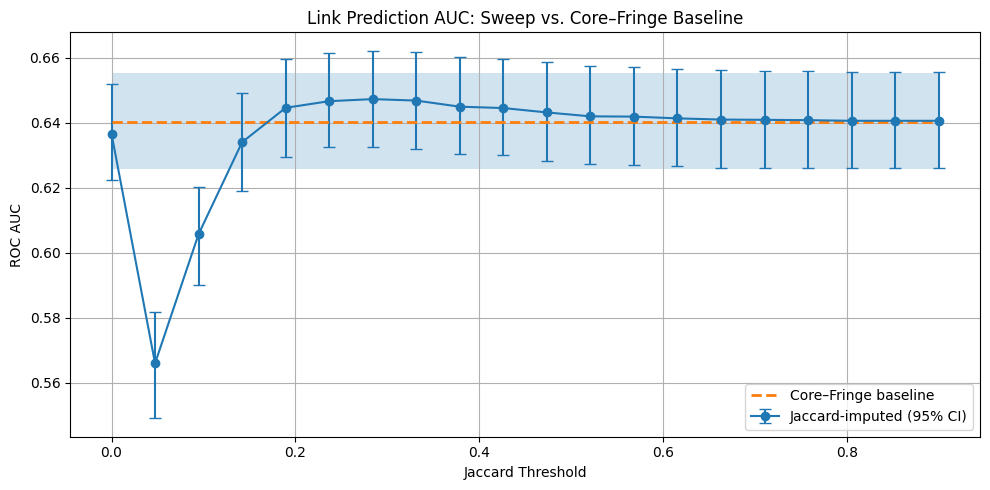

Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6403
AUC for class 2: 0.6403
AUC 95% CI: [0.626, 0.655]

Final Results:
Test Accuracy: 0.5925
Test ROC AUC: 0.6403
Possible FF Edges: 25346190 	 Added Edges : 25346190

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6366
AUC for class 2: 0.6366
AUC 95% CI: [0.622, 0.652]

Final Results:
Test Accuracy: 0.4926
Test ROC AUC: 0.6366
Possible FF Edges: 25346190 	 Added Edges : 24998908

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6215
AUC for class 2: 0.6223
AUC 95% CI: [0.607, 0.638]

Final Res

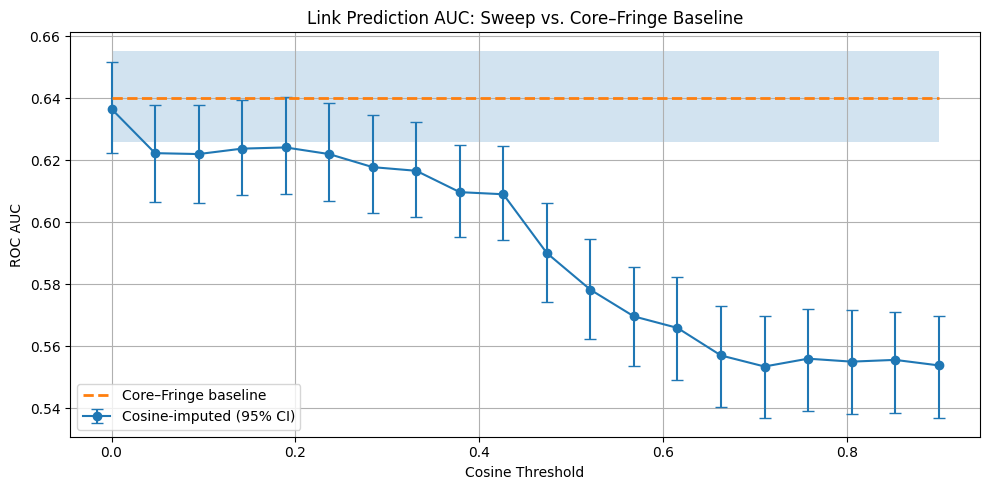

Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6403
AUC for class 2: 0.6403
AUC 95% CI: [0.626, 0.655]

Final Results:
Test Accuracy: 0.5925
Test ROC AUC: 0.6403
Possible FF Edges: 25346190 	 Added Edges : 25346190

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6366
AUC for class 2: 0.6366
AUC 95% CI: [0.622, 0.652]

Final Results:
Test Accuracy: 0.4926
Test ROC AUC: 0.6366
Possible FF Edges: 25346190 	 Added Edges : 3223108

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.5458
AUC for class 2: 0.5458
AUC 95% CI: [0.529, 0.563]

Final Resu

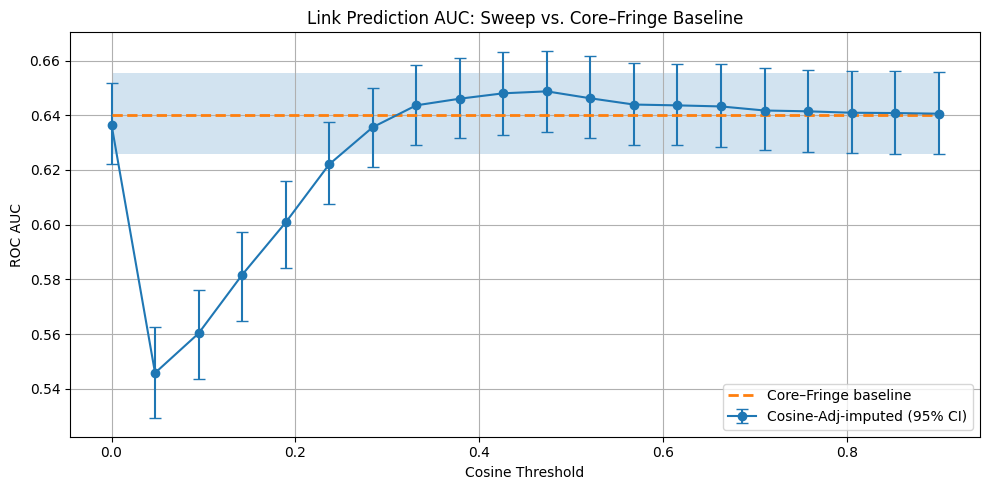

Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6403
AUC for class 2: 0.6403
AUC 95% CI: [0.626, 0.655]

Final Results:
Test Accuracy: 0.5925
Test ROC AUC: 0.6403
Possible FF Edges: 25346190 	 Added Edges : 25346190

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6366
AUC for class 2: 0.6366
AUC 95% CI: [0.622, 0.652]

Final Results:
Test Accuracy: 0.4926
Test ROC AUC: 0.6366
Possible FF Edges: 25346190 	 Added Edges : 3522282

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.5466
AUC for class 2: 0.5466
AUC 95% CI: [0.530, 0.564]

Final Resu

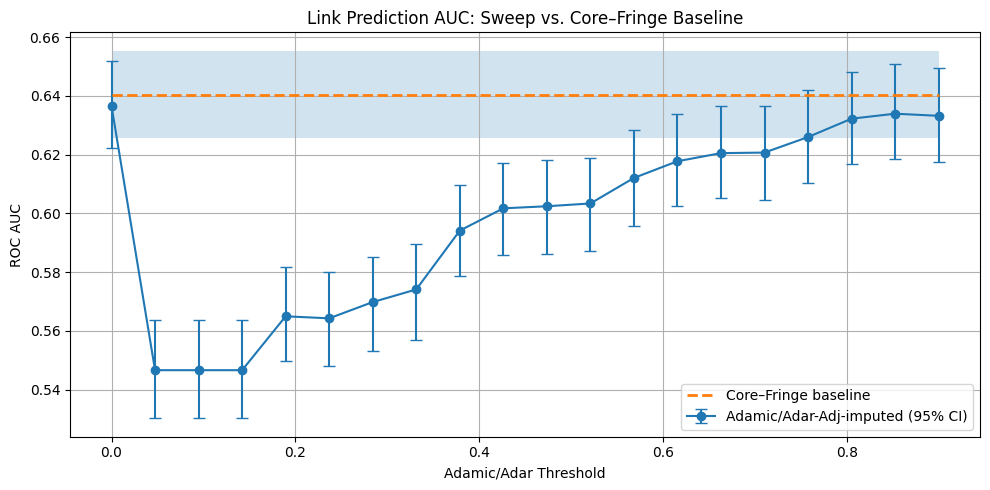

{'thresholds': array([0.        , 0.04736842, 0.09473684, 0.14210526, 0.18947368,
        0.23684211, 0.28421053, 0.33157895, 0.37894737, 0.42631579,
        0.47368421, 0.52105263, 0.56842105, 0.61578947, 0.66315789,
        0.71052632, 0.75789474, 0.80526316, 0.85263158, 0.9       ]),
 'sweep_aucs': [0.6365953064831766,
  0.5466059592197463,
  0.5466059592197463,
  0.5466059592197463,
  0.5649499715927024,
  0.5642653557224923,
  0.5697934158197083,
  0.5740930181175431,
  0.5941260021463293,
  0.6017206931380594,
  0.6024194337478694,
  0.6033663436651727,
  0.6120618174357679,
  0.6177513256738842,
  0.6205047818950824,
  0.6206985827914905,
  0.6259864434063507,
  0.6322347863139952,
  0.6339349630705133,
  0.6332088409822613],
 'sweep_cis': [(0.6222559939302452, 0.6517479870382437),
  (0.5302122411677682, 0.5636338131467098),
  (0.5302122411677682, 0.5636338131467098),
  (0.5302122411677682, 0.5636338131467098),
  (0.5497089644994133, 0.5817703502106895),
  (0.5480283633198387, 0

In [10]:
jaccard_threshold_sweep()
cosine_threshold_sweep()
cosine_adj_threshold_sweep()
adamic_adar_threshold_sweep()

In [11]:
def percentage_sweep():
    percentages = np.linspace(0.1, 1.0, 10)
     # Seed and generate Yale Core-Fringe 
    seed = random.seed(datetime.now().timestamp())
    adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
    chosen_dorms_list = [[np.uint(31), np.uint(32)]]
    adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)
    aucs = {'core-fringe' : [], 'jaccard_ff_imputation' : [], 'cosine_ff_imputation' : [], 'cosine_adj_ff_imputation' : [], 'adamic_adar_ff_imputation' : []}
    auc_cis = {'core-fringe' : [], 'jaccard_ff_imputation' : [], 'cosine_ff_imputation' : [], 'cosine_adj_ff_imputation' : [], 'adamic_adar_ff_imputation' : []}
    added_edges = {'core-fringe' : [], 'jaccard_ff_imputation' : [], 'cosine_ff_imputation' : [], 'cosine_adj_ff_imputation' : [], 'adamic_adar_ff_imputation' : []}
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    total_possible_edges = len(fringe_indices) * (len(fringe_indices) - 1)
    for p in percentages:
        labelled_core_indices = np.random.choice(core_indices, size=int(p * len(core_indices)), replace=False)
        _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=1.0, ff_imputation=None
        )
        _, _, auc, auc_ci, jaccard_added_edges = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=0.3, ff_imputation='jaccard'
        )
        _, _, cosine_auc, cosine_auc_ci, cosine_added_edges = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=0.5, ff_imputation='cosine'
        )

        _, _, cosine_adj_auc, cosine_adj_auc_ci, cosine_adj_added_edges = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=0.5, ff_imputation='cosine_adj'
        )
        _, _, aa_auc, aa_auc_ci, aa_added_edges = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=0.9, ff_imputation='adamic_adar'
        )
        aucs['core-fringe'].append(cf_auc)
        aucs['jaccard_ff_imputation'].append(auc)
        aucs['cosine_ff_imputation'].append(cosine_auc)
        aucs['cosine_adj_ff_imputation'].append(cosine_adj_auc)
        aucs['adamic_adar_ff_imputation'].append(aa_auc)
        auc_cis['core-fringe'].append(cf_ci)
        auc_cis['jaccard_ff_imputation'].append(auc_ci)
        auc_cis['cosine_ff_imputation'].append(cosine_auc_ci)
        auc_cis['cosine_adj_ff_imputation'].append(cosine_adj_auc_ci)
        auc_cis['adamic_adar_ff_imputation'].append(aa_auc_ci)
        added_edges['core-fringe'].append((cf_added * 2) / total_possible_edges)
        added_edges['jaccard_ff_imputation'].append((jaccard_added_edges * 2) / total_possible_edges)
        added_edges['cosine_ff_imputation'].append((cosine_added_edges * 2) / total_possible_edges)
        added_edges['cosine_adj_ff_imputation'].append((cosine_adj_added_edges * 2) / total_possible_edges)
        added_edges['adamic_adar_ff_imputation'].append((aa_added_edges * 2) / total_possible_edges)
    
    
    # Prepare error bars for sweep
    lowers = {}
    uppers = {}
    for key in aucs:
        lowers[key] = [auc - ci[0] for auc, ci in zip(aucs[key], auc_cis[key])]
        uppers[key] = [ci[1] - auc for auc, ci in zip(aucs[key], auc_cis[key])]

    
    # Plot
    plt.figure(figsize=(10, 5))

    # Jaccard sweep with error bars
    for key in aucs:
        
        plt.errorbar(
            percentages, aucs[key],
            yerr=[lowers[key], uppers[key]],
            fmt='-o', capsize=4,
            label=f'{key} (95% CI)'
        )
        
    plt.xlabel("Percent Labelled Core")
    plt.ylabel("ROC AUC")
    plt.title("Core-Fringe vs FF Imputation (Labelled Percentage Sweeep)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    for key in added_edges:
        plt.plot(percentages, added_edges[key], label=key)
    plt.xlabel("Percent Labelled Core")
    plt.ylabel("Percentage of Added Edges")
    plt.title("Percentage of Added Edges (Labelled Percentage Sweep)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687

 Feature Space (Core-Fringe)
X_train shape: (97, 6421)
y_train shape: (97,)
Unique training classes: [1 2]
AUC for class 1: 0.5527
AUC for class 2: 0.5527
AUC 95% CI: [0.537, 0.568]

Final Results:
Test Accuracy: 0.5005
Test ROC AUC: 0.5527
Possible FF Edges: 25346190 	 Added Edges : 24766

 Feature Space (Core-Fringe)
X_train shape: (97, 6421)
y_train shape: (97,)
Unique training classes: [1 2]
AUC for class 1: 0.5597
AUC for class 2: 0.5597
AUC 95% CI: [0.544, 0.575]

Final Results:
Test Accuracy: 0.5057
Test ROC AUC: 0.5597
Possible FF Edges: 25346190 	 Added Edges : 4612272

 Feature Space (Core-Fringe)
X_train shape: (97, 6421)
y_train shape: (97,)
Unique training classes: [1 2]
AUC for class 1: 0.5331
AUC for class 2: 0.5352
AUC 95% CI: [0.519, 0.552]

Final Results:
Test

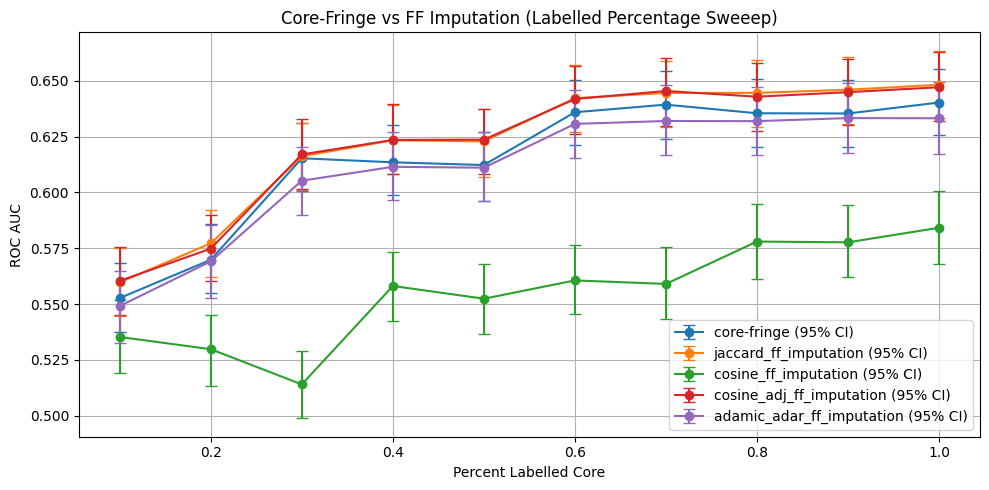

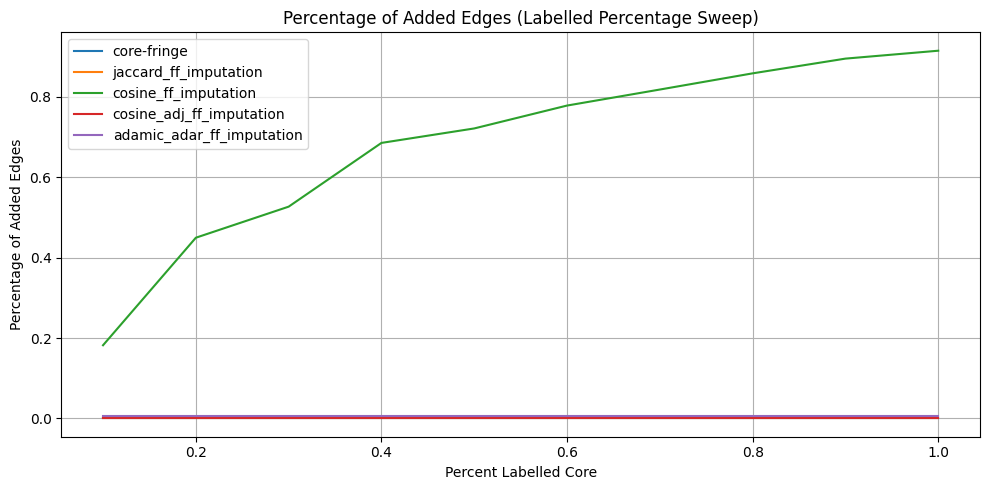

In [12]:
percentage_sweep()

Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6403
AUC for class 2: 0.6403
AUC 95% CI: [0.626, 0.655]

Final Results:
Test Accuracy: 0.5925
Test ROC AUC: 0.6403
Possible FF pairs : 25346190 	 Added Edges : 25346190

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6366
AUC for class 2: 0.6366
AUC 95% CI: [0.622, 0.652]

Final Results:
Test Accuracy: 0.4926
Test ROC AUC: 0.6366
Possible FF pairs : 25346190 	 Added Edges : 1594094

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.5505
AUC for class 2: 0.5505
AUC 95% CI: [0.536, 0.566]

Final Re

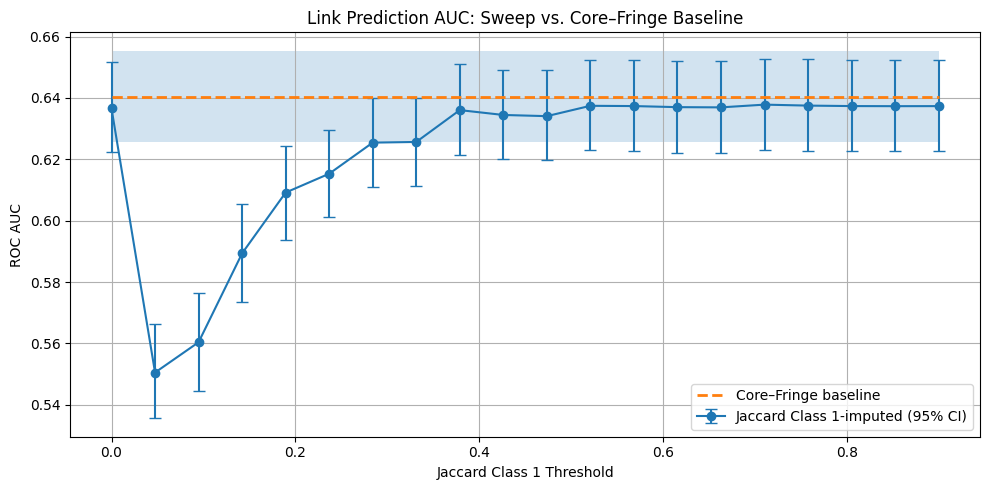

Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6403
AUC for class 2: 0.6403
AUC 95% CI: [0.626, 0.655]

Final Results:
Test Accuracy: 0.5925
Test ROC AUC: 0.6403
Possible FF pairs : 25346190 	 Added Edges : 25346190

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6366
AUC for class 2: 0.6366
AUC 95% CI: [0.622, 0.652]

Final Results:
Test Accuracy: 0.4926
Test ROC AUC: 0.6366
Possible FF pairs : 25346190 	 Added Edges : 1763030

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.5330
AUC for class 2: 0.5330
AUC 95% CI: [0.516, 0.549]

Final Re

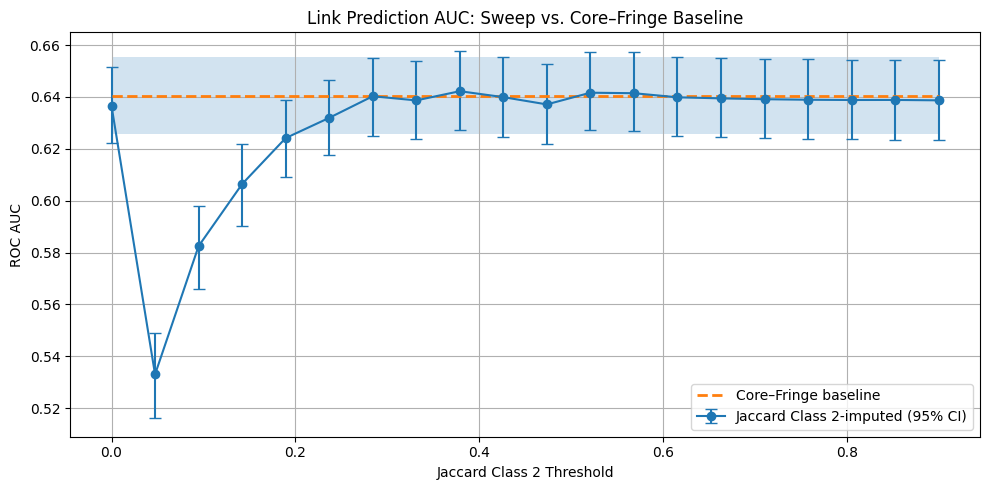

{'thresholds': array([0.        , 0.04736842, 0.09473684, 0.14210526, 0.18947368,
        0.23684211, 0.28421053, 0.33157895, 0.37894737, 0.42631579,
        0.47368421, 0.52105263, 0.56842105, 0.61578947, 0.66315789,
        0.71052632, 0.75789474, 0.80526316, 0.85263158, 0.9       ]),
 'sweep_aucs': [0.6365953064831766,
  0.533011568082823,
  0.5824717505208005,
  0.6064204437851146,
  0.6241533047156114,
  0.631944163878543,
  0.6402845464301496,
  0.6386809544851966,
  0.6422294994002904,
  0.6399387664920144,
  0.6371343349536014,
  0.6416458083454327,
  0.6414539012688593,
  0.6398769806199104,
  0.6394664951707594,
  0.6391399690676094,
  0.638931175430844,
  0.6388361688024746,
  0.6388555804557794,
  0.6387067577804433],
 'sweep_cis': [(0.6222559939302452, 0.6517479870382437),
  (0.5160753174983536, 0.5491207745994398),
  (0.5660707544847282, 0.598058479631963),
  (0.5902605030076256, 0.6217134492597789),
  (0.6090858563928473, 0.6387934878903152),
  (0.6176314060332679, 0.646

In [12]:
jaccard_class_1_threshold_sweep()
jaccard_class_2_threshold_sweep()

In [41]:
def fill_fringe_fringe_jaccard_bootstrap(adj_matrix, fringe_indices, threshold=0.5, k=1):
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    total_added_edges = 0
    for r in range(k):
        # go over all pairs of fringe-fringe and compute the jaccard sim of their adj_list
        # and if above threshold add an edge between the nodes and return this A_pred
        neighbor_set = {}
        for node in fringe_indices:
            neighbor_set[node] = set(np.nonzero(A_pred[node])[0])

        L = len(fringe_indices)
        added_edges = 0
        for i in range(L):
            u = fringe_indices[i]
            for j in range(i+1, L):
                v = fringe_indices[j]
                
                # skip if already added edge
                if A_pred[u, v] > 0:
                    continue
                    
                neighbors_u = neighbor_set[u]
                neighbors_v = neighbor_set[v]

                union_size = len(neighbors_u | neighbors_v)
                if union_size == 0:
                    sim = 0.0
                else:
                    sim = len(neighbors_u & neighbors_v) / union_size 
                # print(f"Jaccard Sim: {sim}")
                if sim >= threshold - (r / 10):
                    A_pred[u,v] = 1.0
                    A_pred[v,u] = 1.0
                    added_edges += 1
        total_added_edges += added_edges
        print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2} in round {r+1}")
    return A_pred, total_added_edges


def logistic_regression_model_bootstrap(
    adj_matrix, core_indices, 
    fringe_indices, metadata, 
    feature='link', lr_kwargs=None, 
    seed=None, threshold=0.5,
    ff_imputation='jaccard', 
    k=1
):
    gender = metadata[:, 1].astype(int)  # Convert to integer
    dorm = metadata[:, 4]
    added_edges = 0
    if ff_imputation == 'jaccard_bootstrap':
        # impute the fringe-fringe edges 
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_jaccard_bootstrap(adj_matrix, fringe_indices, threshold=threshold, k=k)
    else:
        ff_imputed_adj_matrix = adj_matrix
    if feature == 'link':
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
    elif feature == 'triangles':
        # @toDo: implement this
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
    elif feature == 'node2vec':
        # @toDo: implement this
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
        
    print("\n Feature Space (Core-Fringe)")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    y_test = gender[fringe_indices]
    unique_train_classes = np.unique(y_train)
    print(f"Unique training classes: {unique_train_classes}")
    model = LogisticRegression(**lr_kwargs, random_state=seed)
    model.fit(X_train, y_train)
    beta = model.coef_.flatten()
    # print(f"\nModel Analysis:")
    # print(f"Number of non-zero coefficients: {np.count_nonzero(beta)}")
    # print(f"Mean absolute coefficient: {np.mean(np.abs(beta)):.4f}")
    # print(f"Max coefficient: {np.max(np.abs(beta)):.4f}")
    # print(f"Min coefficient: {np.min(np.abs(beta)):.4f}")
    # print(f"Max coefficient (No-Abs): {np.max(beta):.4f}")
    # print(f"Min coefficient (No-Abs): {np.min(beta):.4f}")

    y_test_pred = model.predict(X_test)
    y_test_scores = model.predict_proba(X_test)
    
    # Verify class order and AUC calculation
    # print("\nClass Order Verification:")
    # print(f"Model classes_: {model.classes_}")  # Order of classes in the model
    # print(f"Unique test classes: {np.unique(y_test)}")  # Classes in test set
    # print(f"Class distribution in test: {dict(Counter(y_test))}")
    # print(f"Prediction distribution: {dict(Counter(y_test_pred))}")

    # Calculate AUC for each class
    for i, class_label in enumerate(model.classes_):
        class_auc = roc_auc_score(y_test == class_label, y_test_scores[:, i])
        print(f"AUC for class {class_label}: {class_auc:.4f}")
    
    # Use the correct class index for AUC
    positive_class_idx = np.where(model.classes_ == 2)[0][0]  # Assuming 2 is our positive class
    auc = roc_auc_score(y_test, y_test_scores[:, positive_class_idx])
    accuracy = accuracy_score(y_test, y_test_pred)
    
    # Compute AUC confidence interval
    auc_lower, auc_upper = auc_confidence_interval(y_test, y_test_scores[:, positive_class_idx])
    print(f"AUC 95% CI: [{auc_lower:.3f}, {auc_upper:.3f}]")
    
    print(f"\nFinal Results:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC AUC: {auc:.4f}")
    # print(f"Training class distribution: {dict(Counter(y_train))}")
    # print(f"Test class distribution: {dict(Counter(y_test))}")

    return beta, accuracy, auc, (auc_lower, auc_upper), added_edges




In [40]:
seed = random.seed(datetime.now().timestamp())
adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
chosen_dorms_list = [[np.uint(31), np.uint(32)]]
print(adj_matrix.shape)
print(metadata.shape)
print(metadata[:, 1].shape)
adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)
print(adj_matrix.shape)
print(len(core_indices))
print(len(fringe_indices))
lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
_, acc, auc, auc_ci, added_edges = logistic_regression_model_bootstrap(adj_matrix, core_indices, fringe_indices, 
                                                metadata, feature='link', lr_kwargs=lr_kwargs, 
                                                seed=seed, threshold=0.30, ff_imputation='jaccard_bootstrap', k=3)
L = len(fringe_indices)
print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")

(6421, 6421)
(6421, 7)
(6421,)
Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687
(6421, 6421)
976
5035
Possible FF Edges: 25346190 	 Added Edges : 24766 in round 1
Possible FF Edges: 25346190 	 Added Edges : 25574 in round 2
Possible FF Edges: 25346190 	 Added Edges : 104156 in round 3

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6386
AUC for class 2: 0.6386
AUC 95% CI: [0.623, 0.654]

Final Results:
Test Accuracy: 0.5958
Test ROC AUC: 0.6386
Possible FF Edges: 25346190 	 Added Edges : 154496


In [43]:
def logistic_regression_model_extended(
    adj_matrix, core_indices, 
    fringe_indices, metadata, 
    feature='link', lr_kwargs=None, 
    seed=None, threshold=0.5,
    ff_imputation='jaccard'
):
    import numpy as np
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score, accuracy_score
    from scipy import sparse as sp

    # --- helpers -------------------------------------------------------------
    def _to_csr(A):
        if sp.issparse(A):
            return A.tocsr().astype(float)
        return sp.csr_matrix(A, dtype=float)

    def _symmetrize_remove_selfloops(A):
        A = A.maximum(A.T)
        A.setdiag(0.0)
        A.eliminate_zeros()
        return A

    def _row_normalize(A):
        deg = np.asarray(A.sum(axis=1)).ravel()
        inv = np.zeros_like(deg, dtype=float)
        inv[deg > 0] = 1.0 / deg[deg > 0]
        Dinv = sp.diags(inv)
        return Dinv @ A

    def _deepwalk_svd_embeddings(A, dim=64, walk_length=5, random_state=None):
        from sklearn.decomposition import TruncatedSVD
        P = _row_normalize(A)
        M = P.tocsr().copy()
        Pk = P.tocsr().copy()
        for _ in range(2, walk_length + 1):
            Pk = Pk @ P
            M = M + Pk
            M.eliminate_zeros()
        svd = TruncatedSVD(n_components=dim, random_state=random_state)
        Z = svd.fit_transform(M)
        return Z

    def _random_walk_sequences(A, num_walks=10, walk_length=10, rng=None):
        n = A.shape[0]
        indptr, indices, data = A.indptr, A.indices, A.data
        if rng is None:
            rng = np.random.default_rng()
        walks, nodes = [], np.arange(n)
        for _ in range(num_walks):
            rng.shuffle(nodes)
            for start in nodes:
                deg_start = indptr[start + 1] - indptr[start]
                if deg_start == 0:
                    walks.append([str(start)])
                    continue
                walk = [start]
                cur = start
                for _ in range(walk_length - 1):
                    ptr0, ptr1 = indptr[cur], indptr[cur + 1]
                    neigh = indices[ptr0:ptr1]
                    w = data[ptr0:ptr1]
                    if neigh.size == 0:
                        break
                    probs = w / w.sum()
                    cur = rng.choice(neigh, p=probs)
                    walk.append(cur)
                walks.append([str(x) for x in walk])
        return walks

    def _node2vec_embeddings_gensim(A, dim=64, num_walks=10, walk_length=10,
                                    window_size=5, epochs=5, workers=1, seed=None):
        try:
            from gensim.models import Word2Vec
            walks = _random_walk_sequences(A, num_walks=num_walks, walk_length=walk_length,
                                           rng=np.random.default_rng(seed))
            model = Word2Vec(
                sentences=walks,
                vector_size=dim,
                window=window_size,
                min_count=0,
                sg=1, negative=5, hs=0,
                workers=workers,
                seed=seed,
                epochs=epochs
            )
            n = A.shape[0]
            Z = np.zeros((n, dim), dtype=np.float32)
            for i in range(n):
                key = str(i)
                if key in model.wv:
                    Z[i] = model.wv[key]
            return Z
        except Exception:
            return _deepwalk_svd_embeddings(A, dim=dim, walk_length=walk_length, random_state=seed)

    def _triangle_features(A, core_idx, fringe_idx):
        """
        Compute per-node triangle-based features on a symmetrized, loop-free CSR matrix A.
        Returns an (n, d) feature matrix with:
        [deg_total, deg_core, deg_fringe, tri_total, clustering,
         tri_CFC(fringe, two cores),
         tri_CFF_fringe(fringe, one core one fringe),
         tri_FFF(fringe, two fringes),
         tri_CCC(core, two cores),
         tri_CCF(core, one core one fringe),
         tri_CFF_core(core, two fringes)]
        """
        n = A.shape[0]
        C = np.array(core_idx, dtype=int)
        F = np.array(fringe_idx, dtype=int)

        # Degrees
        deg_total = np.asarray(A.sum(axis=1)).ravel()
        deg_core  = np.asarray(A[:, C].sum(axis=1)).ravel()
        deg_fringe = deg_total - deg_core

        # Total triangles per node using (A^2 ⊙ A) row-sum / 2
        A2 = A @ A
        tri_total = np.asarray((A2.multiply(A)).sum(axis=1)).ravel() / 2.0

        # Clustering coefficient
        clus = np.zeros(n, dtype=float)
        mask = deg_total >= 2
        clus[mask] = (2.0 * tri_total[mask]) / (deg_total[mask] * (deg_total[mask] - 1.0))

        # Blocks
        A_cc = A[C][:, C]
        A_cf = A[C][:, F]
        A_fc = A[F][:, C]  # = A_cf.T
        A_ff = A[F][:, F]

        # Initialize typed triangle arrays
        tri_CFC = np.zeros(n, dtype=float)          # F-anchored: two cores
        tri_CFF_fringe = np.zeros(n, dtype=float)   # F-anchored: one core, one fringe
        tri_FFF = np.zeros(n, dtype=float)          # F-anchored: two fringes
        tri_CCC = np.zeros(n, dtype=float)          # C-anchored: two cores
        tri_CCF = np.zeros(n, dtype=float)          # C-anchored: one core, one fringe
        tri_CFF_core = np.zeros(n, dtype=float)     # C-anchored: two fringes

        # Fringe-anchored typed triangles
        if F.size > 0:
            # CFC: diag(A_FC * A_CC * A_CF) / 2 (two cores => double-count)
            if C.size > 0:
                tmp_f = (A_fc @ A_cc) @ A_cf
                tri_CFC[F] = tmp_f.diagonal() / 2.0
            # CFF (fringe-anchored): diag(A_FF * A_FC * A_CF) (no double-count)
            if (A_ff.shape[0] > 0) and (C.size > 0):
                tmp_f2 = (A_ff @ A_fc) @ A_cf
                tri_CFF_fringe[F] = tmp_f2.diagonal()
            # FFF: ((A_FF^2 ⊙ A_FF) row-sum) / 2
            if A_ff.shape[0] > 0:
                A_ff2 = A_ff @ A_ff
                tri_FFF[F] = np.asarray((A_ff2.multiply(A_ff)).sum(axis=1)).ravel() / 2.0

        # Core-anchored typed triangles
        if C.size > 0:
            # CCC: ((A_CC^2 ⊙ A_CC) row-sum) / 2
            A_cc2 = A_cc @ A_cc
            tri_CCC[C] = np.asarray((A_cc2.multiply(A_cc)).sum(axis=1)).ravel() / 2.0
            # CCF: diag(A_CC * A_CF * A_FC) (no double-count)
            if F.size > 0:
                tmp_c1 = (A_cc @ A_cf) @ A_fc
                tri_CCF[C] = tmp_c1.diagonal()
                # CFF (core-anchored): diag(A_CF * A_FF * A_FC) / 2 (two fringes => double-count)
                tmp_c2 = (A_cf @ A_ff) @ A_fc
                tri_CFF_core[C] = tmp_c2.diagonal() / 2.0

        # Stack features
        X = np.column_stack([
            deg_total, deg_core, deg_fringe,
            tri_total, clus,
            tri_CFC, tri_CFF_fringe, tri_FFF,
            tri_CCC, tri_CCF, tri_CFF_core
        ])
        return X

    # --- main ---------------------------------------------------------------
    if lr_kwargs is None:
        lr_kwargs = dict(max_iter=200, C=1.0, solver='lbfgs')

    gender = metadata[:, 1].astype(int)  # Convert to integer
    dorm = metadata[:, 4]                # kept for parity (unused here)

    # Impute FF edges using existing methods/names
    added_edges = 0
    if ff_imputation == 'jaccard':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_jaccard(adj_matrix, fringe_indices, threshold=threshold)
    elif ff_imputation == 'cosine':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_cosine(adj_matrix, core_indices, fringe_indices, gender, threshold=threshold)
    elif ff_imputation == 'cosine_adj':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_cosine_adj(adj_matrix, fringe_indices, gender, threshold=threshold)
    elif ff_imputation == 'adamic_adar':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_adamic_adar(adj_matrix, fringe_indices, gender, threshold=threshold)
    elif ff_imputation == 'inverse_jaccard':
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_jaccard_inverse(adj_matrix, fringe_indices, threshold=threshold)
    else:
        ff_imputed_adj_matrix = adj_matrix

    # Prepare features
    if feature == 'link':
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test  = ff_imputed_adj_matrix[fringe_indices, :]

    elif feature == 'triangles':
        # Build triangle-based features on the augmented graph
        A = _to_csr(ff_imputed_adj_matrix)
        A = _symmetrize_remove_selfloops(A)
        X_all = _triangle_features(A, core_indices, fringe_indices)
        X_train = X_all[core_indices]
        y_train = gender[core_indices]
        X_test  = X_all[fringe_indices]

    elif feature in ('node2vec', 'random_walk'):
        A = _to_csr(ff_imputed_adj_matrix)
        A = _symmetrize_remove_selfloops(A)
        emb_dim, num_walks, walk_length = 64, 10, 10
        window_size, epochs, workers = 5, 5, 1
        Z = _node2vec_embeddings_gensim(
            A, dim=emb_dim, num_walks=num_walks, walk_length=walk_length,
            window_size=window_size, epochs=epochs, workers=workers, seed=seed
        )
        X_train = Z[core_indices]
        y_train = gender[core_indices]
        X_test  = Z[fringe_indices]

    else:
        raise ValueError(f"Unknown feature type: {feature}")

    # Train LR on core, evaluate on fringe
    print("\n Feature Space (Core-Fringe)")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    y_test = gender[fringe_indices]
    unique_train_classes = np.unique(y_train)
    print(f"Unique training classes: {unique_train_classes}")

    model = LogisticRegression(**lr_kwargs, random_state=seed)
    model.fit(X_train, y_train)
    beta = model.coef_.flatten()

    y_test_pred = model.predict(X_test)
    y_test_scores = model.predict_proba(X_test)

    for i, class_label in enumerate(model.classes_):
        class_auc = roc_auc_score(y_test == class_label, y_test_scores[:, i])
        print(f"AUC for class {class_label}: {class_auc:.4f}")

    # Assuming 2 is the positive class
    positive_class_idx = np.where(model.classes_ == 2)[0][0]
    auc = roc_auc_score(y_test, y_test_scores[:, positive_class_idx])
    accuracy = accuracy_score(y_test, y_test_pred)

    auc_lower, auc_upper = auc_confidence_interval(y_test, y_test_scores[:, positive_class_idx])
    print(f"AUC 95% CI: [{auc_lower:.3f}, {auc_upper:.3f}]")

    print(f"\nFinal Results:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC AUC: {auc:.4f}")

    return beta, accuracy, auc, (auc_lower, auc_upper), added_edges


In [44]:
seed = random.seed(datetime.now().timestamp())
adj_matrix, metadata = parse_fb100_mat_file("/Users/pranaymundra/Desktop/research_code/core-fringe-attribute-prediction/data/fb100/Yale4.mat")
chosen_dorms_list = [[np.uint(31), np.uint(32)]]
print(adj_matrix.shape)
print(metadata.shape)
print(metadata[:, 1].shape)
adj_matrix, core_indices, fringe_indices = create_multi_dorm_core_fringe_graph(adj_matrix, metadata, chosen_dorms_list)
print(adj_matrix.shape)
print(len(core_indices))
print(len(fringe_indices))
lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
_, acc, auc, auc_ci, added_edges = logistic_regression_model_extended(adj_matrix, core_indices, fringe_indices, 
                                                metadata, feature='node2vec', lr_kwargs=lr_kwargs, 
                                                seed=seed, threshold=0.3, ff_imputation='jaccard')
L = len(fringe_indices)
print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")

_, acc, auc, auc_ci, added_edges = logistic_regression_model_extended(adj_matrix, core_indices, fringe_indices, 
                                                metadata, feature='triangles', lr_kwargs=lr_kwargs, 
                                                seed=seed, threshold=0.3, ff_imputation='jaccard')
L = len(fringe_indices)
print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")

(6421, 6421)
(6421, 7)
(6421,)
Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687
(6421, 6421)
976
5035
Possible FF Edges: 25346190 	 Added Edges : 24766

 Feature Space (Core-Fringe)
X_train shape: (976, 64)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6048
AUC for class 2: 0.6048
AUC 95% CI: [0.589, 0.620]

Final Results:
Test Accuracy: 0.5728
Test ROC AUC: 0.6048
Possible FF Edges: 25346190 	 Added Edges : 24766
Possible FF Edges: 25346190 	 Added Edges : 24766

 Feature Space (Core-Fringe)
X_train shape: (976, 11)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.5271
AUC for class 2: 0.5271
AUC 95% CI: [0.511, 0.543]

Final Results:
Test Accuracy: 0.5116
Test ROC AUC: 0.5271
Possible FF Edges: 25346190 	 Added Edges : 24766


Total edges in original adjacency: 289808
Multi-dorm core using dormIDs [[31, 32]]
Core size: 976
Number of core-core edges: 16817
Number of core-fringe edges: 27304
Number of fringe-fringe edges (lost): 245687

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6403
AUC for class 2: 0.6403
AUC 95% CI: [0.626, 0.655]

Final Results:
Test Accuracy: 0.5925
Test ROC AUC: 0.6403
Possible FF pairs: 25346190 	 Added Edges : 9719102

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.5000
AUC for class 2: 0.5000
AUC 95% CI: [0.500, 0.500]

Final Results:
Test Accuracy: 0.5074
Test ROC AUC: 0.5000
Possible FF pairs: 25346190 	 Added Edges : 76058

 Feature Space (Core-Fringe)
X_train shape: (976, 6421)
y_train shape: (976,)
Unique training classes: [1 2]
AUC for class 1: 0.6037
AUC for class 2: 0.6037
AUC 95% CI: [0.589, 0.620]

Final Results

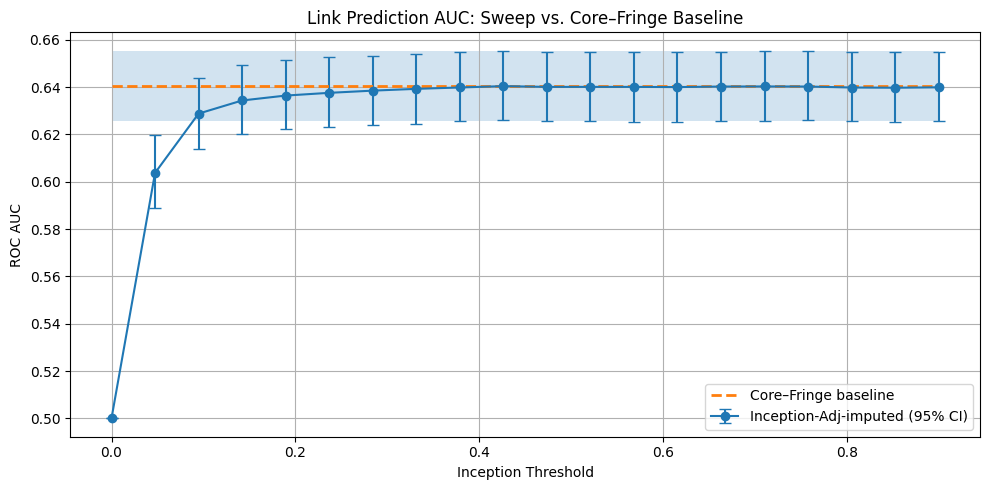

{'thresholds': array([0.        , 0.04736842, 0.09473684, 0.14210526, 0.18947368,
        0.23684211, 0.28421053, 0.33157895, 0.37894737, 0.42631579,
        0.47368421, 0.52105263, 0.56842105, 0.61578947, 0.66315789,
        0.71052632, 0.75789474, 0.80526316, 0.85263158, 0.9       ]),
 'sweep_aucs': [0.5,
  0.6037300359825768,
  0.6287909538539234,
  0.6343436336089893,
  0.6364165772362856,
  0.6375727542453129,
  0.638502461965785,
  0.6392596742629885,
  0.6398369736759043,
  0.6404098541758727,
  0.6400920080802979,
  0.6400920080802979,
  0.6400872735307115,
  0.6400129411022031,
  0.640234518022852,
  0.6402787071523262,
  0.6402397260273971,
  0.6398273467584118,
  0.6397318666750836,
  0.6399034151884351],
 'sweep_cis': [(0.5, 0.5),
  (0.5887038220833234, 0.6199170863795859),
  (0.6138384966131525, 0.6440246445581387),
  (0.6203110523312909, 0.6491607856139188),
  (0.6221625233405338, 0.6514660004104895),
  (0.6229314510350556, 0.652519705541222),
  (0.6238404234234547, 0.653

In [63]:
inception_threshold_sweep()